# Recreation of Unrolled Optimization with Deep Priors

In this notebook, I recreate one of the neural networks proposed in *Unrolled Optimization of Deep Priors* by Diamond et al. and apply it to the BSDS500 dataset.



# Introduction

One common way to approach signal processing problems is using an iterative optimization framework. That is to say, signal processing problems like image restoration can be described as a minimization or maximzation function. It is also common for model developers to further describe theoptimization problem in a Bayesian framework, where the regularization term is a prior.

In general in Bayesian statistics, you as the creator have to decide what a good prior is, which is well-known as a pain point in the methodology. In the paper *Unrolled Optimization with Deep Priors*, the authors circumvent choosing a prior by using neural networks to choose the prior for them. The way they went about this is to create a residual network with embedded CNNs that determine a good prior through training.

In this notebook, I apply the pseudocode described in the paper to the problem of image denoising.

# Prerequisite knowledge

In this section, I describe several topics that are necessary to understand in order to understand the author's algorithm.

## Image denosiing in the bayesian framework

Let us call our true image x. We will imagine there is some distribution $\Omega()$ representing all images. Our true image is drawn from this distribution with parameters $\theta$: $\Omega(\theta)$

The process of the image is being taken and all that happens to it before we see it can be described with the linear operator A.

This transformed image now lives on the noise distribution, $\omega()$. The noisy image we actually measure,y, can be described as being drawn from the noise distribution, $\omega(Ax)$.

With this framing in place, we can describe finding the original image x as solving a MAP problem.

$x = \arg \min_{x} P(y|Ax) P(x, \theta)$

Essentially, this equation says: you choose a clean image that maximizes the log probability of the noisy image coming from the noisy distribution plus the clean image coming from the clean distribution.

if we take the log, we get :
$x = \arg \min_{x} f(y, Ax) + r(x, \theta)$

where $f(y, Ax) = -log P(y|Ax)$ and  $r(x, \theta) = -log P(x, \theta)$

Now, the equation is in the form of an optimization problem.

## Unrolled Iterative Methods

This refers to algorithm unrolling, where you take an iterative algorithm that you run for K times, and you create K blocks of neural networks instead, or run the neural network k times. Usually after each block you add the result to some value: this is a residual neural network.

I cover this topic more in depth in my final ISTA notebook, which the reader can visit for additional information.

# Algorithm Description

The specific algorithm I am implementing is Algorithm 5 from the Supplementary notes. [2] It is a proximal gradient denoising network and the pseudocode is given as:


```
Initialization: x^{0} = y, alpha_k = C^-k, C_0 > 0
for k=0 to N-1 do
  x^(k+1)/2 = CNN(x^k, theta^k)
  x^(k+1) = (alpha_k y + x^k + x^(k+1)/2) / (alpha_k + 1)

```

x^(k+1)/2 represents the prior term, the probability of the original image. x^(k+1) =... represents the prxoimal gradient equation that we are trying to optimize in N-1 iterations. alpha represents step size and is regulated by C which is also a hyperparameter.


# Implementation

## Environment Setup

In [ ]:
# import libraries

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import cv2

# %tensorflow_version 2.x
import tensorflow as tf

import PIL

from skimage.metrics import peak_signal_noise_ratio

If you are running this notebook in Google colab, you can import the data from Google Drive:

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [ ]:
data_dir = './BSDS500'
Xtrain = np.load(os.path.join(data_dir, 'train_noisy_array.npy'))
ytrain = np.load(os.path.join(data_dir, 'train_original_array.npy'))

Xtest = np.load(os.path.join(data_dir, 'test_noisy_array.npy'))
ytest = np.load(os.path.join(data_dir, 'test_original_array.npy'))

Xval = np.load(os.path.join(data_dir, 'val_noisy_array.npy'))
yval = np.load(os.path.join(data_dir, 'val_original_array.npy'))

## Create Model

The authors of the Unrolled Optimization paper have not published their code, but did publish a supplmenetary paper where they state the exact data and network structure they use to achieve their results.

I have preprocessed the data according to their instructions, which can be found in `dataPreprocessing.ipynb`.

In their paper, they state the following specifications:


*   4 iteration proximal gradient network with a 10 layer, 64 channel residual CNN prior
* ReLu nonliniearities
* Xavier initialization
* MSE loss
* parameterized $\alpha_k$ as CkC0, initialized as C0=0 ad Ck = 2-k
* Adam with a learning rate from 0.001 decayed exponentially every 300 epochs
* trauin the model for 134,068 iterations with batch size 4


Out of the specifications they provided, I met all except the last three.


Based on my interpretation of network, I make a residual neural network with four blocks composed of 10 layers each. All my layers are convolutional layers with a 3x3 kernel.

In each block, after the 10 layer block, I transform the output using the optimization equation given in the paper.

In [ ]:
# Define hyperparameters
num_iterations = 4 # How many times the unit repeats
num_CNN_layers = 10 # How many layers inside one unit
initializer = tf.keras.initializers.GlorotNormal()  # Xavier initialization
weight_decay = 0.0001
alpha = 0.5


# Define the inputs
row = 180 # image width
col = 180 # image height
numchannels = 1
input_img = tf.keras.Input(shape=(row,col, numchannels))
x =input_img
y = input_img

# Create the layers
for i in range(num_iterations):
    x_k = x
    # First layer of CNN that reshapes x
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(None, None, numchannels),
                               kernel_initializer=initializer)(x)

    # Nested inner unit layers
    for j in range(num_CNN_layers-2):
        # expand input into cnn
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(x)

    # Last layer to cast to right dimensions
    x = tf.keras.layers.Conv2D(numchannels, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(x)

    # implemnt (αky + xk + xk+1/2)/(αk + 1).
    denom = 1/(1+alpha)
    alpha_y = tf.multiply(alpha, y)
    x_and_x_k = tf.add(x_k, x)
    x_and_y = tf.add(x_and_x_k, alpha_y)
    x = tf.multiply(denom, x_and_y)
    # Put output through last activation function
    x = tf.keras.layers.Activation('relu')(x)

# Final convolution, after units
outputs = tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding='same', activation='relu')(x)#tf.keras.layers.Dense(10, activation='softmax')(x)

# Define the model
model = tf.keras.Model(inputs=input_img, outputs=outputs)

# Print the model summary
model.summary()

# Set optimizer parameters
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, weight_decay=weight_decay)



/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 180, 180, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 180, 180, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

We will create checkpoints during the training loop, so that the intermediate model is saved in case the training stops.

In [ ]:
# Define where to save intermediate model to
checkpoint_path = "./BSDS500/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
# # Compile the model
# model.compile(optimizer=adam, loss='mean_squared_error')

# history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval),
#                     epochs=134068,
#                     batch_size=4,
#                     callbacks=[cp_callback])

I have the number of epochs sent to 134068 because I interpreted the research paper as saying that is what they set their epochs to. However, based on the loss, it seems like the most dramatic decrease in loss has already happened and I did not think it was worth the time to continue. Even though we keyboard interrrupted, the last model is saved in the checkpoints, and we can load as we do below:


In [ ]:
# Load the weights from the last checkpoint
model.load_weights('./BSDS500/cp.ckpt')

# Create Reference Model

Here we will create a simple model that is composed of stacked convolutional layers. The purpose of this model is to compare the performance of the Deep Prior network with a baseline. The model is specifically composed of convolutional layers, so that it mirrors the Deep Prior network.

In [ ]:
row = 180
col = 180
numchannels = 1

# Define input shape
inputs = tf.keras.Input(shape=(row, col, numchannels))

# Define CNN layers
x = tf.keras.layers.Conv2D(64, 3, padding='same')(inputs)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.Conv2D(128, 3, padding='same')(x)
x = tf.keras.layers.Conv2D(128, 3, padding='same')(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)


# Define output layer
outputs = tf.keras.layers.Conv2D(1, 3, padding='same')(x)

# Define model
modelSimple = tf.keras.Model(inputs, outputs)

# Print the model summary
modelSimple.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 1)]     0         
                                                                 
 conv2d_41 (Conv2D)          (None, 180, 180, 64)      640       
                                                                 
 conv2d_42 (Conv2D)          (None, 180, 180, 64)      36928     
                                                                 
 conv2d_43 (Conv2D)          (None, 180, 180, 64)      36928     
                                                                 
 conv2d_44 (Conv2D)          (None, 180, 180, 128)     73856     
                                                                 
 conv2d_45 (Conv2D)          (None, 180, 180, 128)     147584    
                                                                 
 conv2d_46 (Conv2D)          (None, 180, 180, 64)      7379

Again, we can create checkpoints if desired.

In [ ]:
checkpoint_path = "./BSDS500/cpSimple.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [ ]:
modelSimple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

historySimple = modelSimple.fit(Xtrain, ytrain, validation_data=(Xval, yval),
                    epochs=149)

Epoch 1/149
10/10 [==============================] - 40s 2s/step - loss: 35633.3984 - val_loss: 1829.0061
Epoch 2/149
10/10 [==============================] - 5s 549ms/step - loss: 4356.9658 - val_loss: 2711.3687
Epoch 3/149
10/10 [==============================] - 6s 609ms/step - loss: 1567.0471 - val_loss: 1503.9833
Epoch 4/149
10/10 [==============================] - 5s 553ms/step - loss: 850.3413 - val_loss: 875.4874
Epoch 5/149
10/10 [==============================] - 6s 610ms/step - loss: 552.0318 - val_loss: 407.2575
Epoch 6/149
10/10 [==============================] - 6s 561ms/step - loss: 415.3403 - val_loss: 404.5399
Epoch 7/149
10/10 [==============================] - 6s 561ms/step - loss: 375.3007 - val_loss: 383.8569
Epoch 8/149
10/10 [==============================] - 6s 565ms/step - loss: 351.2886 - val_loss: 352.2601
Epoch 9/149
10/10 [==============================] - 6s 566ms/step - loss: 333.3741 - val_loss: 343.5558
Epoch 10/149
10/10 [==============================

# Evaluation

Here, we evaluate the performance of the two models. In order to evaluate the performance of the models, we will be using the Peak Signal to Noise Ratio as the metric. We will first evaluate the performance image by image, to gain an intuition of the performance, then we will evaluate the performance overall.

First we will use the model to make predictions.

In [ ]:
UnrolledDP = model.predict(Xtest)

10/10 [==============================] - 17s 482ms/step


In [ ]:
simpleNN = modelSimple.predict(Xtest)

10/10 [==============================] - 3s 371ms/step


We will create a function to return the PSNR of the image, and plot the original image, its noisy version and the model recreation.

In [ ]:
def evaluateImage(ytest, Xtest, y_pred, ind):
  """
  A function to evaluate the performance of a model on one image, using PSNR.

  Args:
      ytest (_type_): The original image dataset
      Xtest (_type_): The noisy image dataset that went into the ML model
      y_pred (_type_): The images cleaned by the ML model
      ind (_type_): The index to index the three above datasets at. The purpose of this is to evaluate only one image in the dataset, instead of all of them.
  """
  original_image = ytest[ind,]

  # Print out PSNR values
  print(f'PSNR for ML model: \n {peak_signal_noise_ratio(ytest[ind,], y_pred[ind,:,:,0],data_range=original_image.max() - original_image.min())}')
  print(f'PSNR for the original noise image with the clean one : \n {peak_signal_noise_ratio(ytest[ind,], Xtest[ind,],data_range=original_image.max() - original_image.min())}')

  # Plot the images
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))

  axes[0].imshow(y_pred[ind,:,:,0], cmap='gray')
  axes[0].set_title("ML cleaned Image")

  axes[1].imshow(Xtest[ind,:,:], cmap='gray')
  axes[1].set_title("Noisy Image")

  axes[2].imshow(original_image, cmap='gray')
  axes[2].set_title("Original Image")

  plt.show()



PSNR for ML model: 
 24.676205042338665
PSNR for the original noise image with the clean one : 
 20.62350215125064


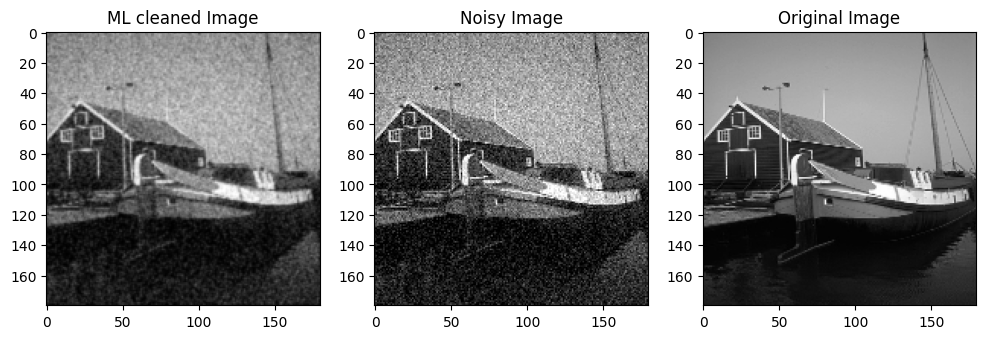

In [ ]:
evaluateImage(ytest, Xtest, UnrolledDP, 9)

PSNR for ML model: 
 25.208165590243627
PSNR for the original noise image with the clean one : 
 20.62350215125064


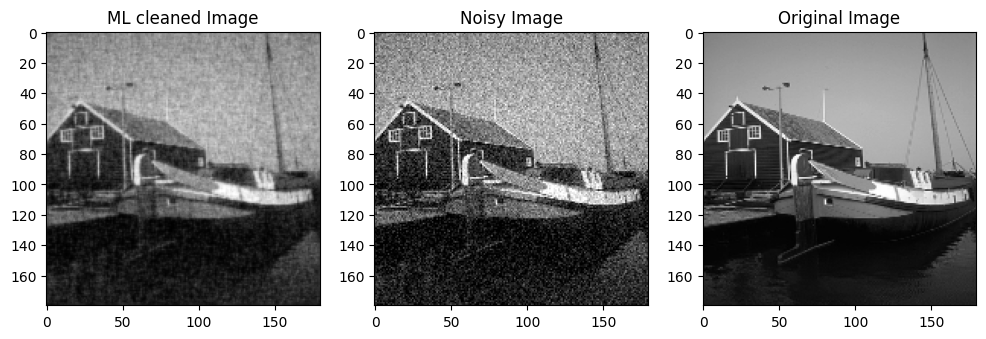

In [ ]:
evaluateImage(ytest, Xtest, simpleNN, 9)

<Analysis>

We can also plot multiple images with their recreations, side-by-side, to get an intuition for the models' performances.

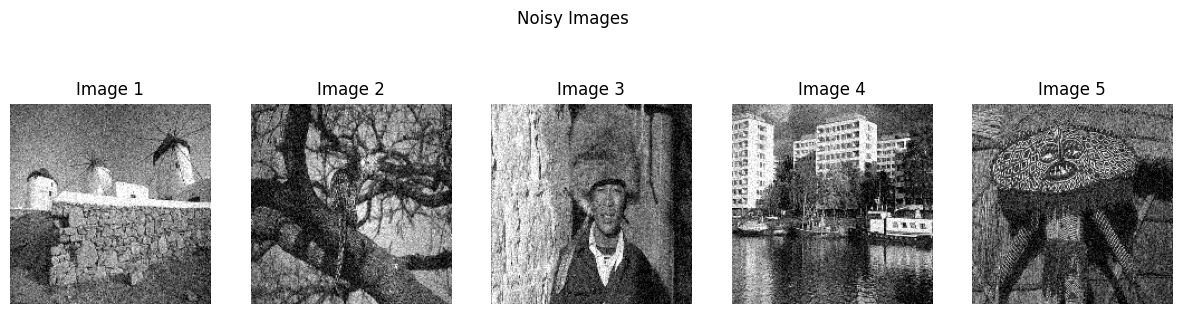

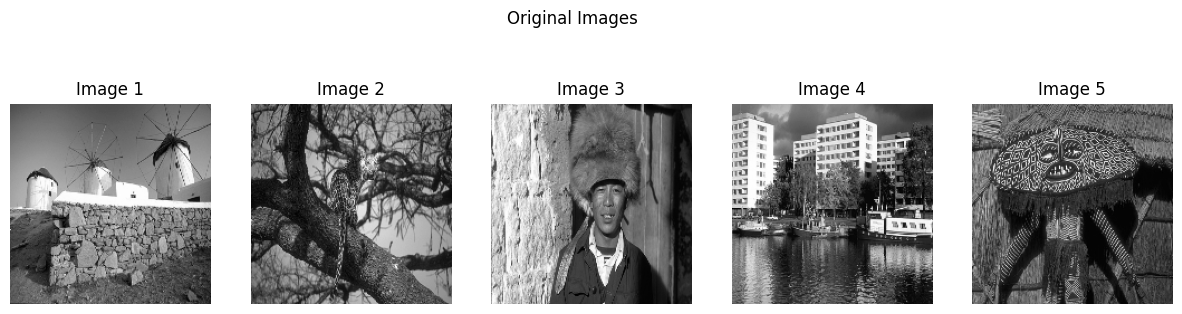

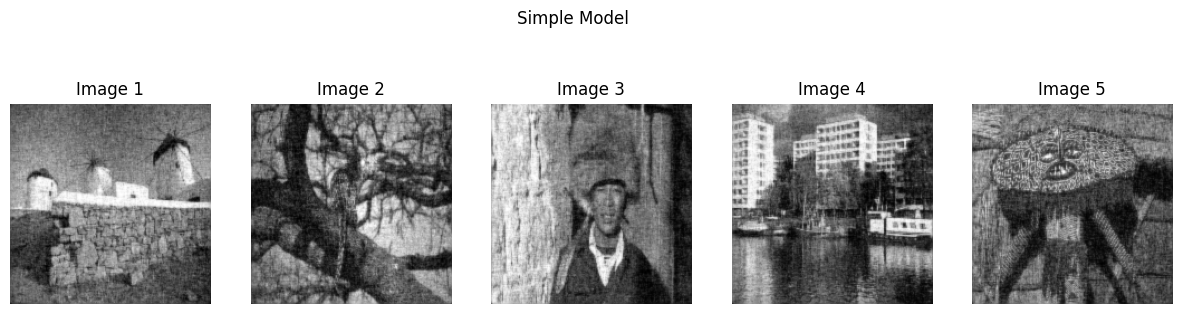

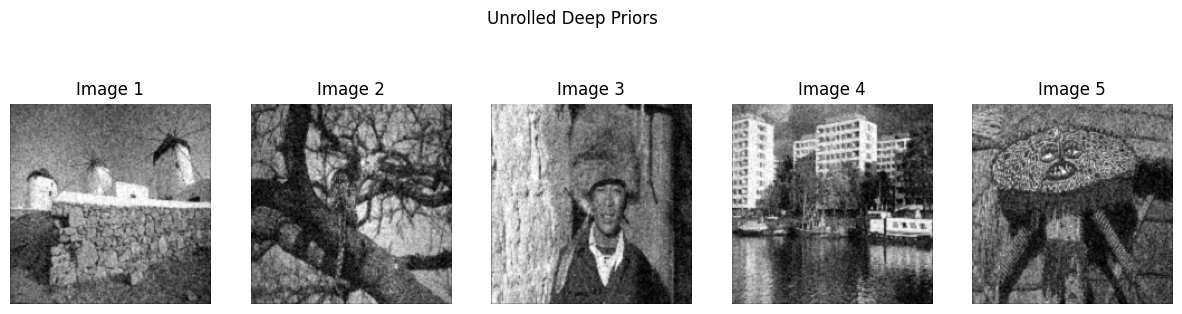

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,4))
for i in range(5):
    axes[i].imshow(Xtest[i,], cmap='gray')
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')
plt.suptitle("Noisy Images")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,4))
for i in range(5):
    axes[i].imshow(ytest[i,], cmap='gray')
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')
plt.suptitle("Original Images")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,4))
for i in range(5):
    axes[i].imshow(simpleNN[i,], cmap='gray')
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')
plt.suptitle("Simple Model")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,4))
for i in range(5):
    axes[i].imshow(UnrolledDP[i,], cmap='gray')
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')
plt.suptitle("Unrolled Deep Priors")
plt.show()

To me, the images cleaned with unrolled optimization still appear quite noisy. However, according to the PSNR values, the model did do something, because the PSNR score is higher than that of the noise.

## Performance over whole model

In order to evaluate the overall performance of the model, we can calculate the average PSNR over all the images in the test set.

In [ ]:
def calcAveragePSNR(ytest, ypred):
    """Calculates the average PSNR over a whole dataset of images, with its noisy or reconstructed counterpart

    Args:
        ytest (_type_): dataset of original images
        ypred (_type_): dataset of reconstructed or noisy images you wish to compare with
    """

    # initialize a list to store the PSNR values
    psnrs = []

    # iterate over the selected indices and compute PSNR for each image
    for ind in range(np.shape(ytest)[0]):
        psnr = peak_signal_noise_ratio(ytest[ind,], ypred[ind,], data_range=255)
        psnrs.append(psnr)

    # compute the average PSNR
    avg_psnr = np.mean(psnrs)

    return avg_psnr

In [ ]:
calcAveragePSNR(ytest, UnrolledDP.squeeze(3))

24.539267088496974

In [ ]:
calcAveragePSNR(ytest, simpleNN.squeeze(3))

24.848180567404025

In [ ]:
calcAveragePSNR(ytest, Xtest)

20.62954483158044

Again, we see that the model recreations are on average about 4 dB better than noise. However, this is still considerably worse than the results from the paper, where the authors achieved an average PSNR of 29.04 for the same data, data processing and noise level. Originally, I believed that my performance was so much worse because I made a mistake in my model. I now suspect that part of the difference in performance could be due to my not adding the last three points in their implementation which were mentioned above. However, the fact that the simple model performs a little bit is also suspicious. With more time, I would implement those points and compare our results again.

# Sources

[1] S. Diamond, V. Sitzmann, F. Heide, and G. Wetzstein, “Unrolled Optimization with Deep Priors.” arXiv, Dec. 18, 2018. Accessed: Mar. 08, 2023. [Online]. Available: http://arxiv.org/abs/1705.08041


[2] S. Diamond, V. Sitzmann, F. Heide, and G. Wetzstein, “Supplementary Information: Unrolled Optimization with Deep Priors”.


[3] P. Xu, D. Ahn, R. Gong, and H. Joshi, “Unrolled Optimization with Deep Priors Applied to Computer-Generated Images from 3D Interactive Environments”.
